# Training our model
In this notebook we will use weave model and graph convolution for our neural network. Both models seem to be promising for virtual screening. I will use the dude_abl.csv file that I have created during my EDA to train my model.
For more explanation please refer to the pdf file in my github


##Importing necessary packages

Deepchem works on tensorflow 1 version so I will change the version of tensorflow:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

In [3]:
import deepchem as dc
from deepchem.models import WeaveModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from deepchem.models import GraphConvModel


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Defining our weave model
def weave_model():
    batch_size = 128
    model = WeaveModel(1, batch_size=batch_size, mode='classification',model_dir="/content")
    return model

#definiting convolution model
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification',model_dir="/content")
    return model
dataset_file = "dude_abl.csv"

### Weave Model

In [0]:
#I will use roc auc score as an initial metric
metrics= [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")]


In [0]:
#Random splitter is a deepchem attribute that splits your dataset randomly
#There is also splitter that can divide by chemical scaffold (ScaffoldS)
#And splitter that can split all the clustered dataset (ButinaSplitter)
splitter= dc.splits.RandomSplitter()
tasks = ["is_active"]
featurizer = dc.feat.WeaveFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks,
smiles_field="Smiles",
featurizer=featurizer)
dataset = loader.featurize(dataset_file, shard_size=8192)
model_1 = weave_model()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
model_1.fit(train_dataset)
train_scores_weave = model_1.evaluate(train_dataset, metrics)
validation_scores_weave = model_1.evaluate(valid_dataset, metrics)


### Graph Convolution Model

In [0]:

splitter= dc.splits.RandomSplitter()
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks,
smiles_field="Smiles",
featurizer=featurizer)

dataset = loader.featurize(dataset_file, shard_size=8192)
model_2 = generate_graph_conv_model()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
model_2.fit(train_dataset)
train_scores_conv = model_2.evaluate(train_dataset, metrics)
validation_scores_conv = model_2.evaluate(valid_dataset, metrics)

In [36]:
print("-------------------------------------WEAVE RESULT----------------------------------------")
print("Train score:")
print(train_scores_weave)
print("Validation score:")
print(validation_scores_weave)
print("-------------------------------------GRAPH CONVOLUTION RESULT-----------------------------")
print("Train score:")
print(train_scores_conv)
print(validation_scores_conv)

-------------------------------------WEAVE RESULT----------------------------------------
Train score:
{'mean-roc_auc_score': 0.5053541978554302}
Validation score:
{'mean-roc_auc_score': 0.5262478485370052}
-------------------------------------GRAPH CONVOLUTION RESULT-----------------------------
Train score:
{'mean-roc_auc_score': 0.9921662062756098}
{'mean-roc_auc_score': 0.9871574208923606}


Above is our model that we can use for virtual screening. Seems like graph convolution model performed better compared to Weave model. 

---



In [17]:
model= model_2
model

GraphConvModel(batch_size=128, dense_layer_size=128, dropout=[0.0, 0.0, 0.0],
               graph_conv_layers=[64, 64], mode='classification', n_classes=2,
               n_tasks=1, number_atom_features=75, uncertainty=False)

## Screening our molecule

In [0]:
import deepchem as dc 
import pandas as pd 
from rdkit.Chem import PandasTools, Draw 
from rdkit import DataStructs 
from rdkit.ML.Cluster import Butina 
from rdkit.Chem import rdMolDescriptors as rdmd 
import seaborn as sns 

In [19]:
featurizer= dc.feat.ConvMolFeaturizer()

df= pd.read_csv("zinc_100k.smi", sep=" ", header=None)
df.columns=["SMILES", "Name"]
rows, cols= df.shape
df["Val"]= [0]*rows
print(df.head(5))

                                              SMILES              Name  Val
0     Cn1ccc(CNC(=O)C(=O)N2C[C@H]3OCCN(C)[C@H]3C2)n1  ZINC000331679912    0
1    C[C@H](C(=O)N(C)C)S(=O)(=O)N1CC(OCC(=O)N(C)C)C1  ZINC000331969909    0
2       COC(=O)C[C@@H](NC(=O)CNC[C@@H]1CCCO1)C(=O)OC  ZINC000430250939    0
3              CC(C)NC(=O)CN1CCN(Cc2nc(N)nc(N)n2)CC1  ZINC000102674242    0
4  CNC(=O)N[C@@H]1CCN(C(=O)[C@H](NC(=O)C2CC2)[C@@...  ZINC000344966326    0


In [0]:
file_name= "zinc.csv"
df.to_csv(file_name, index=False)
loader= dc.data.CSVLoader(tasks=["Val"],
                          smiles_field= "SMILES",
                          featurizer= featurizer)
dataset= loader.featurize(file_name, shard_size=8192)

In [0]:
###As we can see, most of the work is focused on data preparation, prediction of our model takes only 
### one line of code
pred= model.predict(dataset)

,SMILES,Name,Val,Neg,Pos,Mol
50935,Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC...,ZINC13470115,0,0.011463,0.988537,
91977,CN=c1nc(N2CCN(C)CC2)[nH]c(N2CCN(C)CC2)n1,ZINC000343815458,0,0.069493,0.930507,
46469,Cn1nnc(CN2CCN(c3cncc4ncnn43)CC2)n1,ZINC000440511136,0,0.071344,0.928656,
8456,O=C(Nc1cnn(CCN2CCOCC2)c1)NC(CO)CO,ZINC000673872285,0,0.093303,0.906697,
12582,c1cn2nnnc2c(N2CCN(c3nccn4nnnc34)CC2)n1,ZINC000530663975,0,0.106704,0.893296,

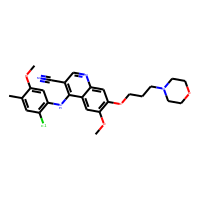
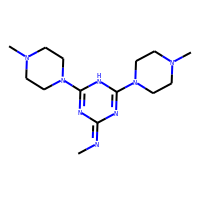
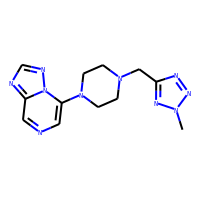
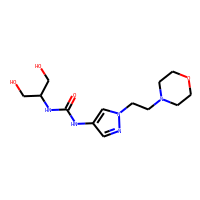
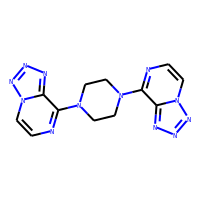

In [22]:
#Making our prediction a dataframe
prediction_df= pd.DataFrame([x.flatten() for x in pred], columns= ["Neg", "Pos"])
combination_df= df.join(prediction_df, how="outer")
combination_df.sort_values("Pos", inplace= True, ascending= False)
PandasTools.AddMoleculeColumnToFrame(combination_df, "SMILES", "Mol")
combination_df.head(5)

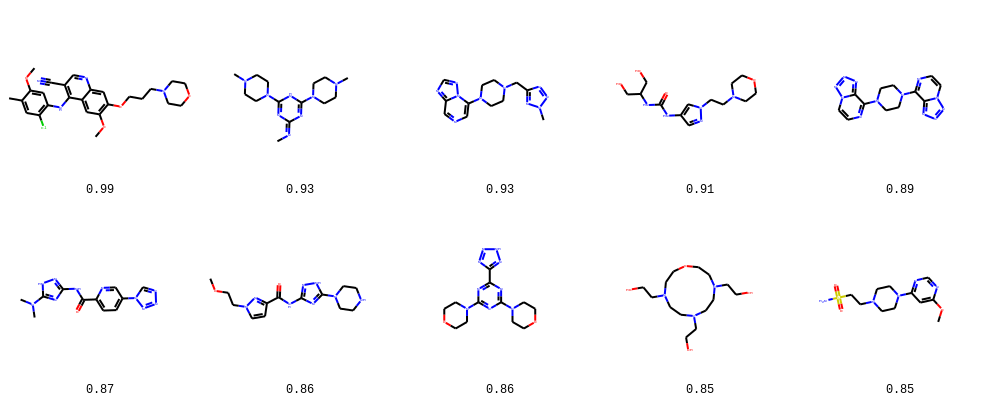

In [23]:
Draw.MolsToGridImage(combination_df.Mol[:10], molsPerRow=5, legends=["%.2f" % x for x in combo_df.Pos[:10]])

## Evaluating Our Molecules

Here, we will try to evaluate molecules that have the highest positive value and see if there are any features that are similar with one and another. Remember that it is up to one's judgement whether to use the molecules or not. We could do a docking experiment prior to synthesizing to get more confirmation regarding the molecule's activity. Alternatively, we can also design our own compound and use the algorithm for prediction.

In [24]:
#Similarity search based on top 5 of the molecule 
combo_smiles =combo_df["SMILES"]
smiles= list(combo_smiles[:5,])
print(smiles)

['Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC4)OC)Cl', 'CN=c1nc(N2CCN(C)CC2)[nH]c(N2CCN(C)CC2)n1', 'Cn1nnc(CN2CCN(c3cncc4ncnn43)CC2)n1', 'O=C(Nc1cnn(CCN2CCOCC2)c1)NC(CO)CO', 'c1cn2nnnc2c(N2CCN(c3nccn4nnnc34)CC2)n1']


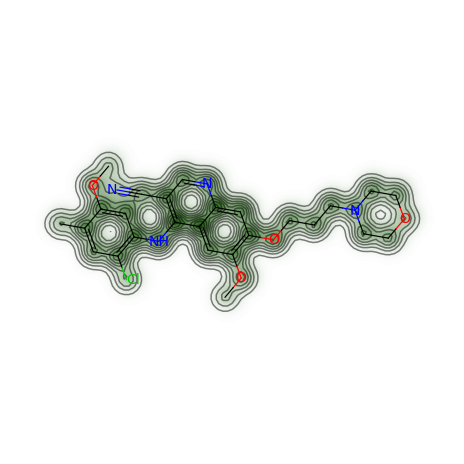

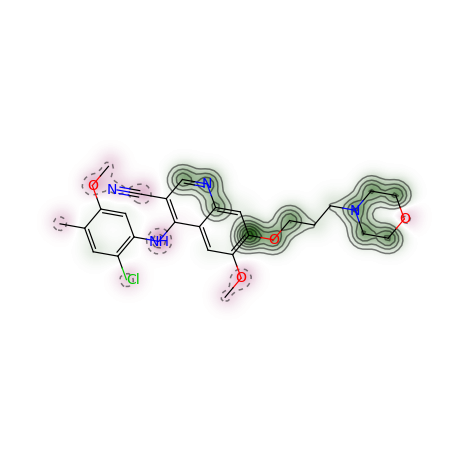

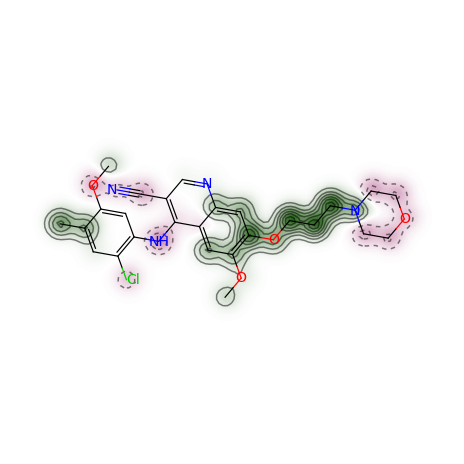

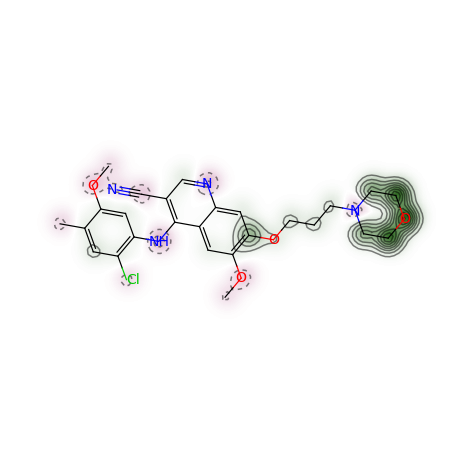

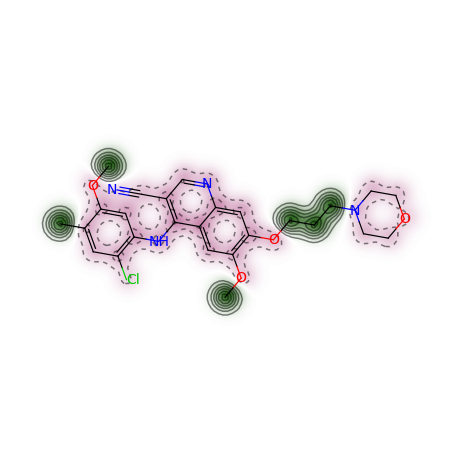

In [32]:
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
mol= Chem.MolFromSmiles('Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC4)OC)Cl')
for i in smiles:
  refmol= Chem.MolFromSmiles(i)
  fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

In [0]:
#Butina Cluster
#Helper code comes from the book: "Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More"
def butina_cluster(mol_list, cutoff=0.90):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
50935,Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC...,ZINC13470115,0,0.011463,0.988537,,1
91977,CN=c1nc(N2CCN(C)CC2)[nH]c(N2CCN(C)CC2)n1,ZINC000343815458,0,0.069493,0.930507,,1
46469,Cn1nnc(CN2CCN(c3cncc4ncnn43)CC2)n1,ZINC000440511136,0,0.071344,0.928656,,1
8456,O=C(Nc1cnn(CCN2CCOCC2)c1)NC(CO)CO,ZINC000673872285,0,0.093303,0.906697,,1
12582,c1cn2nnnc2c(N2CCN(c3nccn4nnnc34)CC2)n1,ZINC000530663975,0,0.106704,0.893296,,2

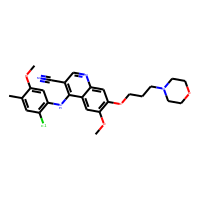
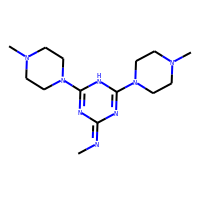
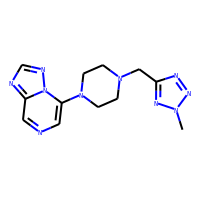
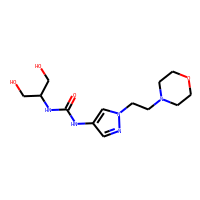
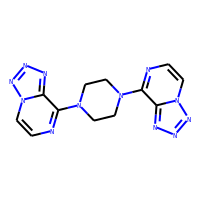

In [34]:
best_100 = combo_df.head(100).copy()
best_100["Cluster"]= butina_cluster(best_100.Mol)
best_100.head()

In [29]:
len(best_100.Cluster.unique())

5

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
50935,Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC...,ZINC13470115,0,0.011463,0.988537,,1
12582,c1cn2nnnc2c(N2CCN(c3nccn4nnnc34)CC2)n1,ZINC000530663975,0,0.106704,0.893296,,2
43180,Cc1nc(=NCCn2cncn2)[nH]c(=NCCn2cncn2)[nH]1,ZINC000433042123,0,0.167124,0.832876,,3
17958,c1c[nH]c(=NC2COCCOC2)c(=NC2COCCOC2)[nH]1,ZINC000644137373,0,0.355564,0.644436,,5
58502,CN(CCN(C)CCS(C)(=O)=O)CCS(C)(=O)=O,ZINC000114718474,0,0.486978,0.513022,,4

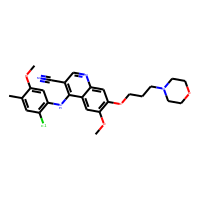
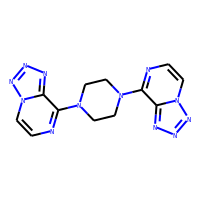
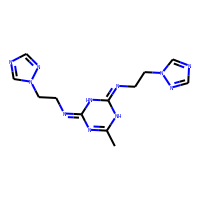
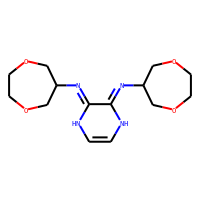
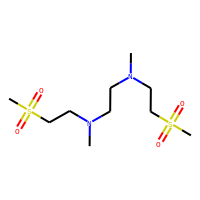

In [30]:
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")
best_cluster_rep_df

In [31]:
best_cluster_smiles =best_cluster_rep_df["SMILES"]
smiles= list(best_cluster_smiles)
print(smiles)

['Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC4)OC)Cl', 'c1cn2nnnc2c(N2CCN(c3nccn4nnnc34)CC2)n1', 'Cc1nc(=NCCn2cncn2)[nH]c(=NCCn2cncn2)[nH]1', 'c1c[nH]c(=NC2COCCOC2)c(=NC2COCCOC2)[nH]1', 'CN(CCN(C)CCS(C)(=O)=O)CCS(C)(=O)=O']


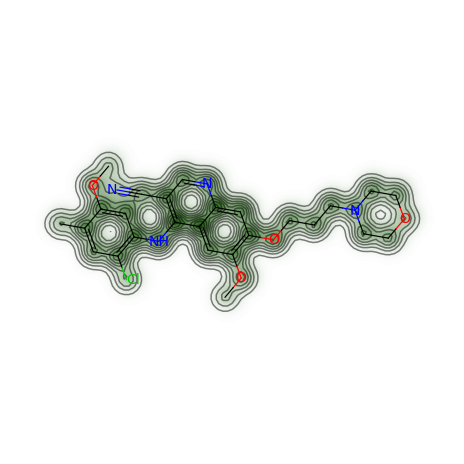

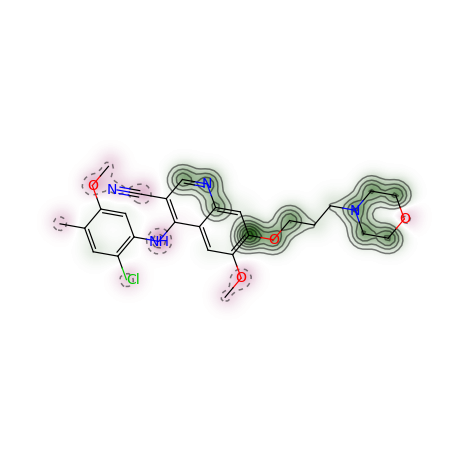

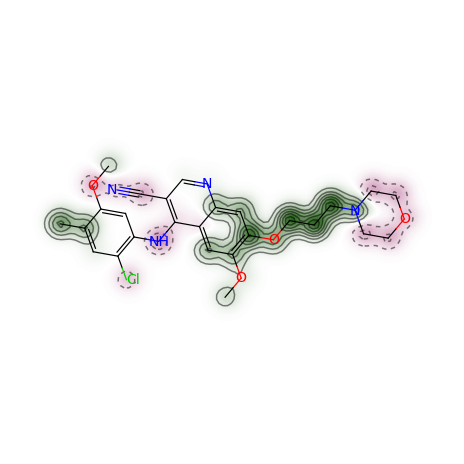

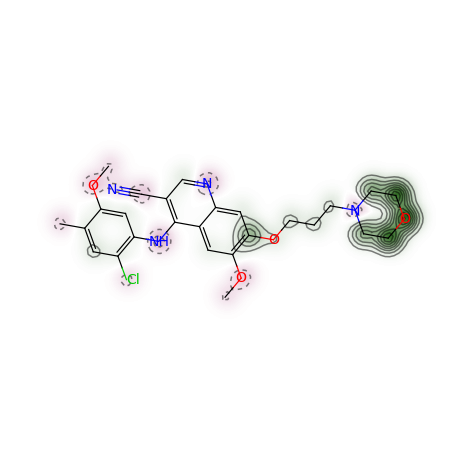

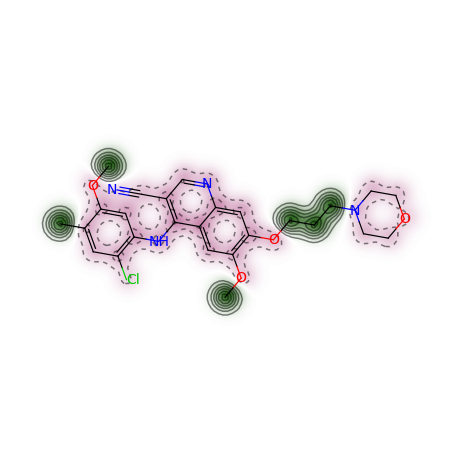

In [35]:
mol= Chem.MolFromSmiles("Cc1cc(c(cc1OC)Nc2c3cc(c(cc3ncc2C#N)OCCCN4CCOCC4)OC)Cl")
for i in smiles:
  refmol= Chem.MolFromSmiles(i)
  fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)